In [707]:
# Load modules
import pandas as pd
import numpy as np
import re

# for plots
import plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *
init_notebook_mode(connected=True)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# for natural language processing
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

In [710]:
# load data set
jobs = pd.read_csv('jobs.csv')

# Need to fix the scraped data and set empty country strings to USA
jobs.loc[jobs['country'].isnull(),'country'] = 'USA'

# Add a country-cyty column
jobs['city_country'] = jobs['city'] + '  (' + jobs['country'] + ")"


In [711]:
# check for Null
print(np.sum(jobs.isnull())) 

# fill na with empty string
jobs=jobs.fillna("")

# Delete empty strings from company data
not_empty_company_names=list(filter(None, jobs['company']))

jobs=jobs.loc[jobs['company'].isin(not_empty_company_names),]

number_of_reviews        0
region                5014
company                103
salary               13015
city                     0
title                    0
country                  0
rating                5305
indeed_id                0
region_code          12130
how_long_open            0
summary                  9
city_country             0
dtype: int64


In [712]:
# Preprocessing of the summary column

# Replace all empty spaces with just one
jobs['summary'] = jobs['summary'].apply(lambda x: re.sub('\s+', ' ', x))

# Get rid of empty strings
jobs = jobs.loc[jobs['summary'] != ""]

In [713]:
# Text processing: Filtering

# Remove puntuation and html format
jobs['summary'] = jobs.summary.str.replace('<.*?>',' ').str.replace('\n',' ')


In [714]:
# Find skills in the summary column
languages_re={'R':'(?<=[\W])R(?=[\W])', 'python':'python', 'Java': 'java', 'Ruby':'ruby','Bash':'bash',\
              'vba':'vba', 'css':'css', 'Javascript':"JAVA-?\s?SCRIPT", 'Scala': 'scala','C':'(?<=[\W])C(?=[\W])',\
             'HTML':'html', 'Perl':'perl', 'SQL':'sql'}

databases_re={ 'Oracle':'oracle', 'MongoDB':'mongodb', 'MySQL':'mysql', 'PostgreSQL':'postgresql', \
             'SQL Server':'sql server', 'Cassandra':'cassandra'}


infrastructures_re={'Hadoop': 'hadoop', 'Spark':'spark', 'AWS':'AWS|[Aa]mazon [Ww]eb [Ss]ervice', 'Hive':'hive',\
                    'Pig':'pig'}

data_science_packages_re={'SAS':'SAS','Matlab':'matlab', 'Tableau':'tableau','TensorFlow':'tensor( ?)flow',\
                          'Excel':'(?<=[\W])Excel(?=[\W])','Stata': 'stata','H2O':'h2o', 'BI':'BI',\
                          'Scikit Learn':'scikit'}

os_re={'Linux': 'linux','windows':'windows', 'mac':'mac '}


skill_re = {'Machine Learning':'ML|[Mm]achine [lL]earning', 'Data Visualization':'visualization',\
            'Deep Learning':'[Dd]eep [Ll]earning','AI':'AI|[Aa]rtificial [Ii]nteligence',\
            'Neural Network':'[Nn]eural ?[Nn]','NLP':'[Nn]atural [Ll]anguage [Pp]rocessing|NLP',\
            'Predictive Modeling':'[Pp]redictive [Mm]odel', 'Web Scraping':'([Ww]eb )?[Ss]crap',\
            'Descision Tree':'[Tt]ree', 'Clustering':'[[Cc]luster' }

tool_re_case_sensitive=['R','SAS', 'C', 'SPSS', 'BI', 'C/C++','Data Visualization','Web Scraping']


all_tools_re = {'Languages':languages_re, 'Databases': databases_re, 'Data Science Tools':data_science_packages_re,\
                'OSes':os_re, 'Infrastructure':infrastructures_re, 'Data Science Methods':skill_re }

skill_groups_df={}

for tool_name, my_df in all_tools_re.items():
    for tool in my_df:
        jobs[tool]=jobs.summary.str.contains(my_df[tool], case = (tool in tool_re_case_sensitive or tool_name=='Data Science Methods' ))
    
    skill_groups_df[tool_name] = (pd.DataFrame(jobs.loc[:,my_df.keys()].apply(pd.value_counts).loc[True].sort_values(ascending=False)))


/Users/elsa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [715]:
layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

bar_layout = Layout(
    barmode='group',
    height=500,
    width=900,
    xaxis=dict(tickangle=-45),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(x="0.82")
)

graph_data = []
for tool_name, my_df in all_tools_re.items():
    graph_data.append(go.Bar(
        x = list(skill_groups_df[tool_name].index),
        y = list(skill_groups_df[tool_name][1]),
        name = tool_name))

py.offline.iplot(Figure(data=graph_data, layout=bar_layout), filename='DS-Skills')

In [716]:
# languages
data=[go.Bar(
        x=skill_groups_df['Languages'].index, 
        y=skill_groups_df['Languages'][1]
        )
     ]
py.offline.iplot(Figure(data=data, layout=layout), filename='languages-barplot')

In [717]:
# Plot skills per city

data = pd.pivot_table(jobs_top25,index=['city_country'],values=tool_re.keys(),aggfunc=[np.mean])
data.columns = data.columns.droplevel()

plot_data = [go.Heatmap( z=data.values.tolist(),
                         y=data.index,
                         x=data.columns,
                        colorscale='Viridis')]

heat_map_layout = Layout(
    margin=go.Margin(
        l=150,
        pad=4
    ),
    height=600,
    width=1000,
    xaxis=dict(tickangle=-45),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    
)

py.offline.iplot(Figure(data=plot_data, layout=heat_map_layout), filename='pandas-heatmap')



In [724]:
# NLP
jobs['corp'] = jobs['summary'].apply(lambda x: " ".join(x.lower() for x in x.split()))
jobs['corp'] = jobs['corp'].apply(lambda x: re.sub('[^\w\s]','', x))


stop = stopwords.words('english') + ['andor','race','color','opportunity','marital','status','gender','etc',\
                                     'including', ' sexual', 'well', 'need', 'various', 'orientation', 'charge', \
                                     'de', 'la', 'year', 'experience', 'equal', 'employer', 'national', 'origin',\
                                     'without', 'regard', 'program', 'support', 'use', 'provide', 'appropriate',\
                                     'user', 'closely', 'work', 'role', 'internal', 'external', 'track','record',\
                                     'based', 'required', 'company', 'working', 'ensure', 'ability', 'organization',\
                                     'successful','candidate', 'scientist','computer', 'best','practice',\
                                     'applicant','application', 'within', 'qualified','applicant','training',\
                                     'related', 'field']

jobs['corp'] = jobs['corp'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [719]:
stemmer = PorterStemmer()

lemztr = WordNetLemmatizer()

jobs_to_wc = jobs
#jobs_to_wc = jobs[jobs['country']!='USA']

text = ''.join(jobs_to_wc['corp'])

text = ' '.join([lemztr.lemmatize(word) for word in text.split()])

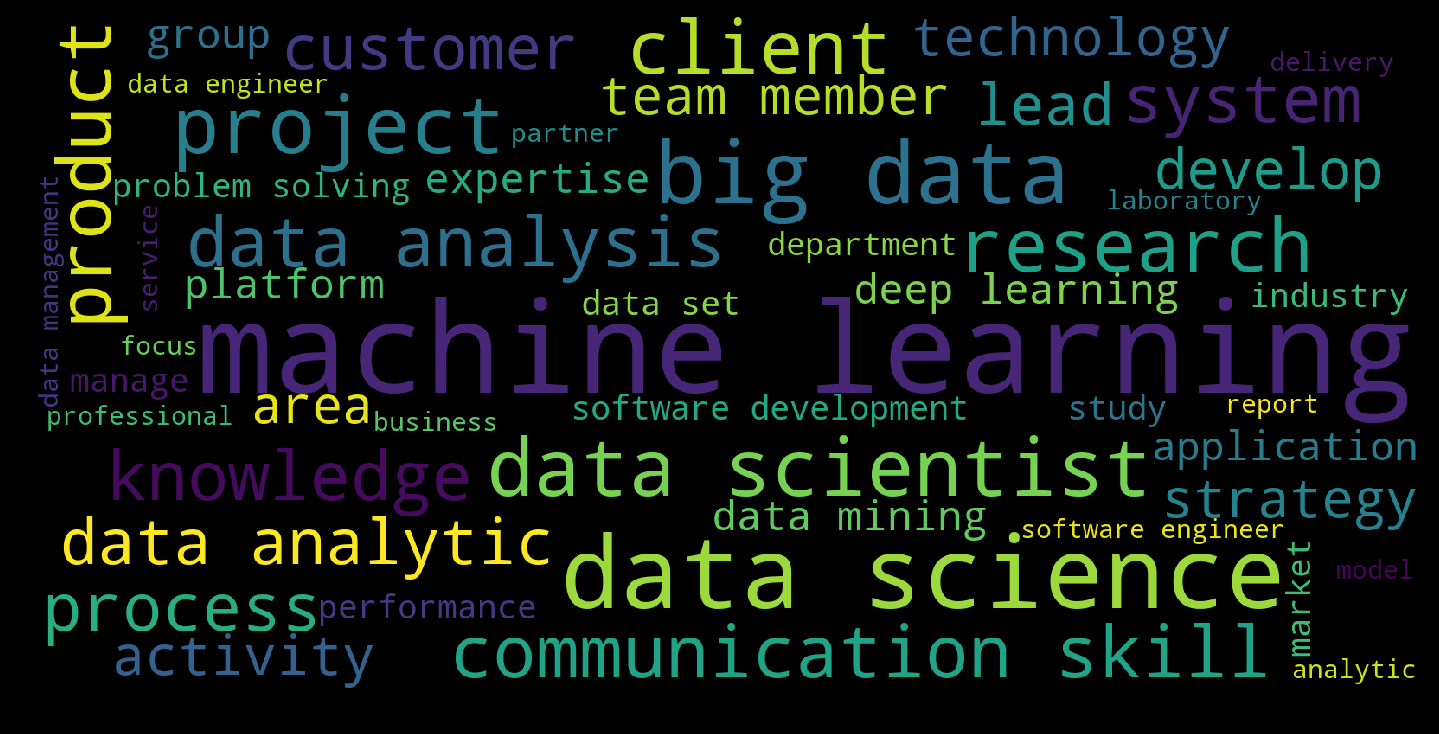

In [720]:
wordcloud = WordCloud(width=1600, height=800, max_words=50).generate(text)
# Open a plot of the generated image.
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [721]:
# degrees

degree_re={'PHD':'(?<=[\W])phd(?=[\W])|ph.d|[Dd]octorate|[Pp]ost graduate','Masters':'[Mm]asters|MS|M.S'\
           ,'Bachelors':'[Bb]achelor|BS|BA|B.A'}

degree_case_sensitive=['Masters','Bachelors']

for degree in degree_re:
    jobs[degree]=jobs.summary.str.contains(degree_re[degree], case= degree in degree_case_sensitive)


In [722]:
title_df=pd.DataFrame(jobs.loc[:,degree_re.keys()].apply(lambda x: pd.value_counts(x,normalize=True)).loc[True].sort_values(ascending=False))

data=[go.Bar(
        x=title_df.index, 
        y=title_df[1]
        )
     ]
py.offline.iplot(data, filename='title-barplot')

In [723]:
# Number of postings for the top 25 cities
by_country_city = jobs.groupby(['city_country','city','country']).size().reset_index(name='count')
top_25_cities = by_country_city.sort_values(by=['count'], ascending=False).head(25)

In [667]:
countries = list(jobs['country'].unique())

graph_data = []
for country in list(top_25_cities.country.unique()):
    job_counts = []
    city_names = []
    cities = list(top_25_cities[top_25_cities['country']==country].city)
    
    for city in cities:
        job_counts.append(top_25_cities[top_25_cities['city'] == city]['count'].values[0])
        city_names.append(city)

    graph_data.append(go.Bar(
        y = job_counts,
        x = city_names,
        name = country))


bar_layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

py.offline.iplot(Figure(data=graph_data, layout=bar_layout), filename='title-barplot_25_top_cities')

In [692]:
# Title per country
graph_data=[]
for country in list(top_25_cities.country.unique()):
    title_df=pd.DataFrame(jobs.loc[jobs['country']==country,degree_re.keys()].apply(lambda x: pd.value_counts(x,normalize=True)).loc[True].sort_values(ascending=False))
    graph_data.append(go.Bar(
            x=title_df.index, 
            y=title_df[1],
            name=country
            ))
    
    
py.plotly.iplot(Figure(data=graph_data, layout=layout), filename='title-title_by_country')

In [699]:
# Top hiring companies for data scientists in the top25 hiring cities
top_25_by_company = jobs.groupby(['company']).size().reset_index(name='count').sort_values(by=['count'], ascending=False).head(25)
data = [go.Bar(
            x=top_25_by_company['company'],
            y=top_25_by_company['count']
    )]

py.offline.iplot(Figure(data=data, layout=layout), filename='title-barplot_25_top_companies')

In [700]:
# Number of postings for the top 25 cities
by_city = jobs.groupby(['city']).size().reset_index(name='count')
top_10_cities = by_country_city.sort_values(by=['count'], ascending=False).head(10)
top_10_cities = list(top_10_cities.city)

graph_data = []
i=1
for city in top_10_cities:
    job_count_by_company = jobs[jobs['city']==city].groupby(['company']).size().reset_index(name='count')
    top_3_companies_in_city = job_count_by_company.sort_values(by=['count'], ascending=False).head(3)

    graph_data.append(go.Bar(
        x = list(top_3_companies_in_city['company']+'-'+str(i)),
        y = list(top_3_companies_in_city['count']),
        name = city))
    i+=1

bar_layout = Layout(
    width=1200,
    height=600,
    barmode='group',
    margin=go.Margin(
        b=150,
        pad=4
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
py.plotly.iplot(Figure(data=graph_data, layout=bar_layout), filename='top10_hirin_companies')

In [679]:
# Normalize salary and degree information

jobs['salary'] = jobs.salary.str.replace('[$|£|₹]','')

conditions = [
    jobs['salary'].str.contains('year', regex=False),
    jobs['salary'].str.contains('month', regex=False),
    jobs['salary'].str.contains('day', regex=False),
    jobs['salary'].str.contains('hour', regex=False)]

multiples = [ 1, 12, 260, 2000 ]
jobs['time_multiplier'] = np.select(conditions, multiples, default=0)

conditions = [
    jobs['country'].str.contains('United Kingdom', regex=False),
    jobs['country'].str.contains('India', regex=False),
    jobs['country'].str.contains('Canada', regex=False),
    jobs['country'].str.contains('Singapore', regex=False),
    jobs['country'].str.contains('Hong Kong', regex=False)
]

multiples = [ 1.3, 0.015, 0.77, 0.73, 0.13 ]
jobs['curency_multiplier'] = np.select(conditions, multiples, default=1.0)

multiples = [ 1.998, 6.4, 2.08, 1.41, 1.31 ]
jobs['col_multiplier'] = np.select(conditions, multiples, default=1.0)

# Impute the degree 
cconditions = [
    jobs['PHD'],
    jobs['Masters'],
    jobs['Bachelors']]

degrees = [ 'PhD', 'Masters', 'Bachelors' ]
jobs['degree'] = np.select(cconditions, degrees, default='Bachelors')


In [680]:
salary_low = jobs.salary.str.replace('[,$]','').str.extract('(\d{5,})[ -]*',expand=False).astype('float')
salary_high = jobs.salary.str.replace('[,$]','').str.extract('[ -*](\d{5,})',expand=False).astype('float')

jobs['salary_high'] = salary_high * jobs['time_multiplier'] * jobs['curency_multiplier']
jobs['salary_low'] = salary_low * jobs['time_multiplier'] * jobs['curency_multiplier']

In [681]:
# Uncomment to fill in the high range
jobs.salary_high.fillna(jobs['salary_low'], inplace=True)

jobs_with_sd = jobs[['salary_low','salary_high','city','country','salary','city_country','col_multiplier','degree']].dropna(thresh=5)
jobs_with_sd['salary_average'] = (jobs_with_sd.salary_low + jobs_with_sd.salary_high) / 2
jobs_with_sd['salary_average_col'] = jobs_with_sd['salary_average'] * jobs_with_sd['col_multiplier']

#jobs_with_sd['salary_average'] = jobs_with_sd.salary_high
#jobs_with_sd['salary_average_col'] = jobs_with_sd['salary_average'] * jobs_with_sd['col_multiplier']

jobs_with_sd.sample(50)


#filtered_jobs = jobs_with_sd[jobs_with_sd.country.isin(["USA","United Kingdom","Canada","India"])]


filtered_jobs = jobs_with_sd[jobs_with_sd.city_country.isin(top_25_cities['city_country'])]

In [691]:
# The countries considered for the salary analysis are the corresponding countries to the top 25 cities except Netherlands and France because there was no salary data
countries = list(filtered_jobs['country'].unique())
countries = [item for item in countries if item not in ["Netherlands","France"]]
graph_data = []

for country in countries:
    cities = filtered_jobs[filtered_jobs['country']==country]['city'].unique()
    cities = [item for item in cities if item not in ["Sunnyvale","Albuquerque"]]
# Change to 'salary_average_col' to get the normalized salary per city   
    for city in cities:
        g_city_salary =(filtered_jobs[filtered_jobs['city']==city]['salary_average_col'])
        g_city_country =(filtered_jobs[filtered_jobs['city']==city]['country'])
        g_city =(filtered_jobs[filtered_jobs['city']==city]['city'])
            
        graph_data.append(go.Box(
                x = g_city_salary,
                y = g_city,
                name = city,
                orientation = 'h',
                customdata = country,
                type = 'box'))


box_layout = Layout(
    yaxis=YAxis(
        zeroline=False
    ),
    height = 1000,
    width = 800,
    boxmode='group',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig = Figure(data=graph_data, layout=box_layout)

py.offline.iplot(fig, filename='salary_by_city_normalyzed')

In [609]:
np.array(filtered_jobs['degree']=='PhD') & np.array(filtered_jobs['country']=='USA')


array([False, False, False, ..., False, False,  True])

In [709]:
data = []

for degree in degrees:
    data.append(go.Box(
        # Add this to filter by country:  & np.array(filtered_jobs['country']=='USA')
        y= filtered_jobs[np.array(filtered_jobs['degree']==degree)]['salary_average'],
        name = degree))
    
py.offline.iplot(Figure(data=data, layout=layout), filename='title_all_not_norm')

In [688]:
data = []

for country in countries:
    data.append(go.Box(
        y= filtered_jobs[filtered_jobs['country']==country]['salary_average_col'],
        name = country))
    
py.offline.iplot(Figure(data=data, layout=layout), filename='salary_by_country_normalized_by_col')

In [677]:
data = []

for country in countries:
    data.append(go.Box(
        y= filtered_jobs[filtered_jobs['country']==country]['salary_average'],
        name = country))
    
py.offline.iplot(Figure(data=data, layout=layout), filename='salary_by_country')